# Imports - Libraries and Data

## Import Libraries

In [2]:
import torch
import copy
import time
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
from torchvision import transforms, datasets
from torch.optim import lr_scheduler
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch.optim as optim
from tqdm import tqdm
import os
from PIL import Image
import matplotlib.image as mpimg
import cv2
import shutil
import torchvision.models as models
import datetime

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Import Data

In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("kmader/skin-cancer-mnist-ham10000")

print("Path to dataset files:", path)

100%|██████████| 5.20G/5.20G [03:53<00:00, 23.9MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/kmader/skin-cancer-mnist-ham10000/versions/2


In [5]:
# List files in the dataset directory
dataset_files = os.listdir(path)
print("Files in the dataset:", dataset_files)


Files in the dataset: ['HAM10000_images_part_1', 'ham10000_images_part_1', 'ham10000_images_part_2', 'HAM10000_images_part_2', 'hmnist_28_28_L.csv', 'hmnist_8_8_L.csv', 'hmnist_8_8_RGB.csv', 'hmnist_28_28_RGB.csv', 'HAM10000_metadata.csv']


# Inspecting dataset (No need to run)

## Viewing the Images

In [ ]:
# Display a few images
image_folder = os.path.join(path, "HAM10000_images_part_1")  # Adjust if necessary
sample_images = os.listdir(image_folder)[10:30]  # Show first 5 images

plt.figure(figsize=(12, 8))
for idx, img_file in enumerate(sample_images):
    img_path = os.path.join(image_folder, img_file)
    img = mpimg.imread(img_path)

    plt.subplot(5, 6, idx + 1)
    plt.imshow(img)
    plt.title(img_file)
    plt.axis("off")

plt.show()

<Figure size 1200x800 with 0 Axes>

## Inspecting the size of the images

In [ ]:
# This is to check if all the images are the same size

# Path to your dataset folder
image_folder = os.path.join(path, "HAM10000_images_part_1") # Adjust if necessary
image_folder2 = os.path.join(path, "HAM10000_images_part_2") # Adjust if necessary

# To store sizes
image_sizes = set()
print(len(os.listdir(image_folder)))
print(len(os.listdir(image_folder2)))

# Loop through all files in the dataset
for image_file in os.listdir(image_folder):
    if image_file.endswith(('.jpg', '.jpeg', '.png')):  # adjust if necessary
        image_path = os.path.join(image_folder, image_file)  # Fixed the path here
        with Image.open(image_path) as img:
            image_sizes.add(img.size)  # Add the size to the set


# Check if all images have the same size
if len(image_sizes) == 1:
    print("All images have the same size:", image_sizes.pop())
else:
    print("Images have different sizes:", image_sizes)



0
0
Images have different sizes: set()


In [ ]:
# Define the path to the image folder (adjust if needed based on output of previous step)
image_folder = os.path.join(path, "HAM10000_images_part_1")

# List the first few images in this folder
sample_images = os.listdir(image_folder)
print("Sample images:", sample_images[:5])

image_path = os.path.join(image_folder, sample_images[0])
# Load image and check dimensions
img = cv2.imread(image_path)
height, width, channels = img.shape
print("Image size:", (width, height))

Sample images: []


IndexError: list index out of range

## Exploratory Data Analysis

### Exploring the hmnist and meta data files

In [ ]:
hmnist_file = os.path.join(path, "hmnist_28_28_RGB.csv")
data = pd.read_csv(hmnist_file)
data

In [ ]:
data.info()
data.columns
data.isnull().any().sum()
y = data['label']
x = data.drop(columns = ['label'])

At this point we can see that as we assumed there are 28 * 28 * 3 + 1 columns for all the 10015 data points. it's multiplied by three for each of RGB and the last col. is the label.
Labels are numbered from 0 to 6.

In [ ]:
meta_data_file = os.path.join(path, "HAM10000_metadata.csv")
meta_data = pd.read_csv(meta_data_file)
meta_data

In [ ]:
#classes = {'mel': 0 ,'vasc': 1,'df': 2,'nv': 3,'bkl': 4,'bcc': 5,'ak': 6}
classes = {4: ('nv', ' melanocytic nevi'), 6: ('mel', 'melanoma'), 2 :('bkl', 'benign keratosis-like lesions'), 1:('bcc' , ' basal cell carcinoma'), 5: ('vasc', ' pyogenic granulomas and hemorrhage'), 0: ('akiec', 'Actinic keratoses and intraepithelial carcinomae'),  3: ('df', 'dermatofibroma')}


### Distribution of Sex

In [ ]:
sns.countplot(x = 'sex', data = meta_data)
plt.xlabel('Sex', size=12)
plt.ylabel('Frequency', size=12)
plt.title('Distribution of Sex', size=16)

### Distribution of Age

In [ ]:
bar, ax = plt.subplots()
sns.histplot(meta_data['age'])
plt.xlabel('Sex', size=12)
plt.ylabel('Frequency', size=12)
plt.title('Histogram of Age of Patients', size=16)

### Distribution of Diseased Areas

In [ ]:
plt.figure()
sns.countplot(x='localization', data=meta_data)
plt.xlabel('Area', size=8)
plt.ylabel('Frequency', size=8)
plt.title('Distribution of Location', size=16)
plt.xticks(rotation=90)
plt.show()

### Distribution of Types

In [ ]:
sns.countplot(x = 'dx', data = meta_data)
plt.xlabel('Disease', size=12)
plt.ylabel('Frequency', size=12)
plt.title('Distribution of Types', size=16)

### Distribution of Types over Gender

In [ ]:
value = meta_data[['localization', 'sex']].value_counts().to_frame()
value.reset_index(level=[1,0 ], inplace=True)
temp = value.rename(columns = {'localization':'location', 0: 'count'})

bar, ax = plt.subplots()
sns.barplot(x = 'location',  y='count', hue = 'sex', data = temp)
plt.title('Location of disease over Gender', size = 16)
plt.xlabel('Disease', size=12)
plt.ylabel('Frequency/Count', size=12)
plt.xticks(rotation = 90)

# Pre-processing images

## Define a custom Dataset class to integrate our data to PyTorch

In [6]:
initial_transform = transforms.Compose([
    transforms.Resize(448),                 # Resize the smaller dimension to 448
    transforms.CenterCrop((448, 448)),
    transforms.ToTensor(),
])

# Define mapping from short codes to labels
label_mapping = {
    "akiec": 0,  # Actinic keratoses and intraepithelial carcinoma / Bowen's disease
    "bcc": 1,    # Basal cell carcinoma
    "bkl": 2,    # Benign keratosis-like lesions
    "df": 3,     # Dermatofibroma
    "mel": 4,    # Melanoma
    "nv": 5,     # Melanocytic nevi
    "vasc": 6    # Vascular lesions
}

In [7]:
class SkinCancerDataset(Dataset):


    def __init__(self, csv_file, img_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the CSV file with annotations.
            img_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on an image.
        """
        self.annotations = csv_file
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        # Get the image path and label
        img_name = os.path.join(self.img_dir, self.annotations.iloc[idx, 1]+".jpg")
        image = Image.open(img_name).convert("RGB")

        # Convert the label to an integer
        label = int(label_mapping.get(self.annotations.iloc[idx, 2], -1))

        # Apply transformations
        if self.transform:
            image = self.transform(image)

        return image, label

## merging part1 and part 2 of images into one directory

In [8]:
# Paths to original folders
path_part_1 = os.path.join(path, "HAM10000_images_part_1")
path_part_2 = os.path.join(path, "HAM10000_images_part_2")
combined_dir = os.path.join(path, "HAM10000_images_combined")


In [9]:

# Create combined directory if it doesn't exist
os.makedirs(combined_dir, exist_ok=True)

def move_all_images(source, destination):
    for filename in os.listdir(source):
        source_path = os.path.join(source, filename)
        destination_path = os.path.join(destination, filename)
        shutil.move(source_path, destination_path)

move_all_images(path_part_1, combined_dir)
move_all_images(path_part_2, combined_dir)

print("Images from both folders have been merged into", combined_dir)

Images from both folders have been merged into /root/.cache/kagglehub/datasets/kmader/skin-cancer-mnist-ham10000/versions/2/HAM10000_images_combined


## Separating images into train, val and test folders according to their labels

In [10]:
csv_file = pd.read_csv(os.path.join(path, "HAM10000_metadata.csv"))
img_dir = os.path.join(path, "HAM10000_images_combined")
output_dir = output_dir = os.path.join(path, "ImageFolder_Dataset")


In [11]:

# Create folders for train, val, and test sets with class subdirectories
for split in ['train', 'val', 'test']:
    for class_name in ["healthy", "not_healthy"]:
        os.makedirs(os.path.join(output_dir, split, class_name), exist_ok=True)

# Helper function to save images into the correct folders
def save_images(dataset, split_name):
    for idx in range(len(dataset)):
        img_name = csv_file.iloc[dataset.indices[idx], 1] + ".jpg"
        img_path = os.path.join(img_dir, img_name)
        label = csv_file.iloc[dataset.indices[idx], 2]
        if label in ["akiec","bcc","mel"]:
          class_name = "not_healthy"  # Use original class names for folders

        else:
          class_name = "healthy"


        dest_folder = os.path.join(output_dir, split_name, class_name)
        dest_path = os.path.join(dest_folder, img_name)

        # Skip copying if the image is already in the folder
        if not os.path.exists(dest_path):
            shutil.copy(img_path, dest_path)
    total_images_split = 0
    # Count the number of images in each folder and print the result
    for class_name in ["healthy", "not_healthy"]:
        class_folder = os.path.join(output_dir, split_name, class_name)
        num_images = len([f for f in os.listdir(class_folder) if f.endswith('.jpg')])
        total_images_split += num_images
        print(f"Number of images in {split_name}/{class_name}: {num_images}")

    print(f"Total number of image in {split_name}: {total_images_split}")
    if split_name != "test":
        print()
        print("--------------------")
        print()

# Split into training, validation, and testing sets
train_size = int(0.8 * len(csv_file))  # 80% training
val_size = int(0.1 * len(csv_file))    # 10% validation
test_size = len(csv_file) - train_size - val_size  # Remaining 10% for testing

# Split dataset indices
torch.manual_seed(42)
full_dataset = SkinCancerDataset(csv_file=csv_file, img_dir=img_dir, transform=None)
train_set, val_set, test_set = random_split(full_dataset, [train_size, val_size, test_size])

# Save images into train, val, and test directories
save_images(train_set, "train")
save_images(val_set, "val")
save_images(test_set, "test")


Number of images in train/healthy: 6466
Number of images in train/not_healthy: 1546
Total number of image in train: 8012

--------------------

Number of images in val/healthy: 797
Number of images in val/not_healthy: 204
Total number of image in val: 1001

--------------------

Number of images in test/healthy: 798
Number of images in test/not_healthy: 204
Total number of image in test: 1002


In [12]:
# Load the train datasets using ImageFolder
train_imagefolder = datasets.ImageFolder(os.path.join(output_dir, "train"), transform=initial_transform)

In [13]:
train_loader = DataLoader(train_imagefolder, batch_size=64, shuffle=False, num_workers=4)

# Calculate mean and standard deviation
mean = 0.0
std = 0.0
num_samples = 0

for images, _ in train_loader:
    batch_samples = images.size(0)
    images = images.view(batch_samples, images.size(1), -1)
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)
    num_samples += batch_samples

mean /= num_samples
std /= num_samples

print("Calculated Mean:", mean)
print("Calculated Standard Deviation:", std)

# Define transform with calculated mean and std for normalization
# Training transform with data augmentation
train_transform = transforms.Compose([
    transforms.Resize(448),                 # Resize the smaller dimension to 448
    transforms.CenterCrop((448, 448)),
    # transforms.RandomHorizontalFlip(),         # Random horizontal flip
    # transforms.RandomRotation(10),            # Random rotation
    # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Color augmentation
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# Validation and test transforms (no augmentation)
test_val_transform = transforms.Compose([
    transforms.Resize(448),                 # Resize the smaller dimension to 448
    transforms.CenterCrop((448, 448)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Calculated Mean: tensor([0.7642, 0.5382, 0.5616])
Calculated Standard Deviation: tensor([0.0880, 0.1209, 0.1365])


In [14]:
# Load the datasets with updated normalization
train_imagefolder = datasets.ImageFolder(os.path.join(output_dir, "train"), transform=train_transform)
val_imagefolder = datasets.ImageFolder(os.path.join(output_dir, "val"), transform=test_val_transform)
test_imagefolder = datasets.ImageFolder(os.path.join(output_dir, "test"), transform=test_val_transform)

## Load data

In [15]:
image_datasets = {'train': train_imagefolder, 'val': val_imagefolder}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

print(class_names)

['healthy', 'not_healthy']


## Inspecting training images

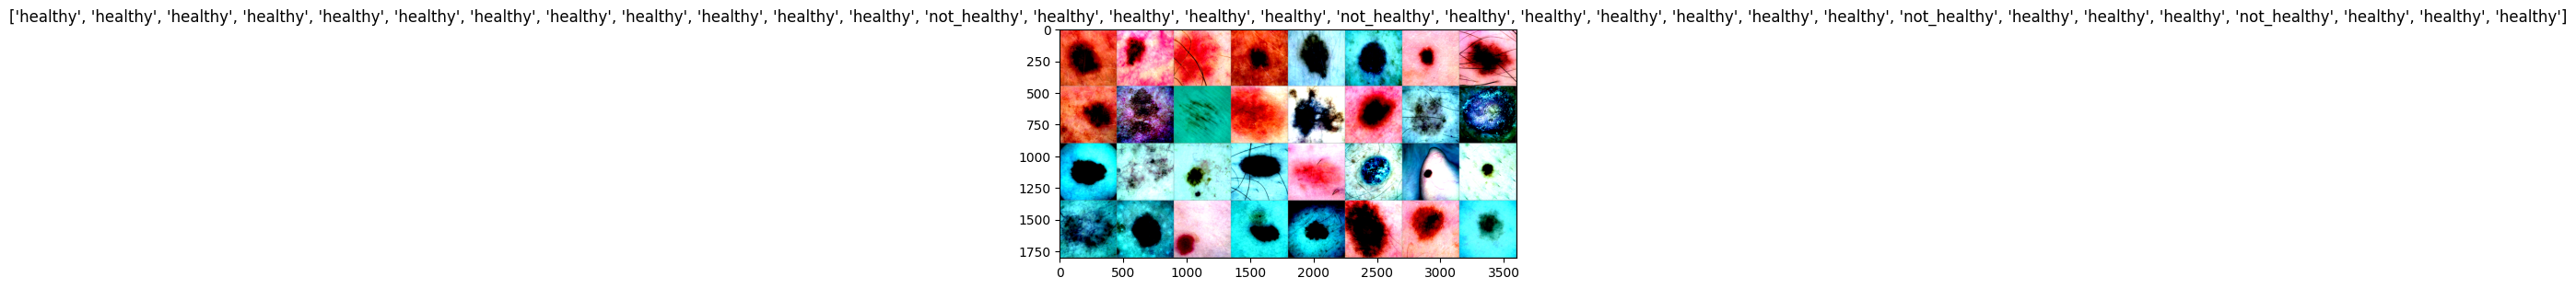

In [16]:
def imshow(inp, title):
    inp = inp.numpy().transpose((1, 2, 0))
    inp = 0.5 * inp + 0.5
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.title(title)
    plt.show()


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

# Model making

## Import VGG16

In [17]:
model_conv = torchvision.models.vgg16(pretrained=True)
# Freeze all layers first
for param in model_conv.parameters():
    param.requires_grad = False

# Unfreeze the last few layers in the feature extractor
for param in list(model_conv.features.parameters())[-10:]:  # ADJUST ==> got better result with more layers unfrozen
    param.requires_grad = True

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 149MB/s] 


## Training the model

In [18]:
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # Initialize lists to store accuracies
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            #if phase == 'train':
                #scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # Store accuracies
            if phase == 'train':
                train_accuracies.append(epoch_acc.item())
            else:
                val_accuracies.append(epoch_acc.item())

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            scheduler.step(epoch_loss)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_accuracies, val_accuracies

In [19]:
# Parameters of newly constructed modules have requires_grad=True
num_ftrs = model_conv.classifier[-1].in_features
model_conv.classifier[-1] = nn.Sequential(
    nn.Linear(num_ftrs, 512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, 2)
)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_conv = optim.Adam(model_conv.classifier.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs

exp_lr_scheduler = lr_scheduler.ReduceLROnPlateau(optimizer_conv, mode='min', factor=0.1, patience=3)

# exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=2, gamma=0.1)

model_conv, train_accuracies, val_accuracies = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.3762 Acc: 0.8238
val Loss: 0.3494 Acc: 0.8292

Epoch 1/24
----------
train Loss: 0.3466 Acc: 0.8356
val Loss: 0.3358 Acc: 0.8402

Epoch 2/24
----------
train Loss: 0.3437 Acc: 0.8379
val Loss: 0.3350 Acc: 0.8452

Epoch 3/24
----------
train Loss: 0.3348 Acc: 0.8410
val Loss: 0.3299 Acc: 0.8521

Epoch 4/24
----------
train Loss: 0.3308 Acc: 0.8482
val Loss: 0.3273 Acc: 0.8501

Epoch 5/24
----------
train Loss: 0.3293 Acc: 0.8452
val Loss: 0.3306 Acc: 0.8531

Epoch 6/24
----------
train Loss: 0.3264 Acc: 0.8482
val Loss: 0.3318 Acc: 0.8541

Epoch 7/24
----------
train Loss: 0.3144 Acc: 0.8512
val Loss: 0.3353 Acc: 0.8482

Epoch 8/24
----------
train Loss: 0.3104 Acc: 0.8573
val Loss: 0.3222 Acc: 0.8561

Epoch 9/24
----------
train Loss: 0.3096 Acc: 0.8563
val Loss: 0.3297 Acc: 0.8551

Epoch 10/24
----------
train Loss: 0.3049 Acc: 0.8566
val Loss: 0.3421 Acc: 0.8531

Epoch 11/24
----------
train Loss: 0.3069 Acc: 0.8591
val Loss: 0.3412 Acc: 0.8362

Ep

## Plot Training and Validation Accuracy per epoch

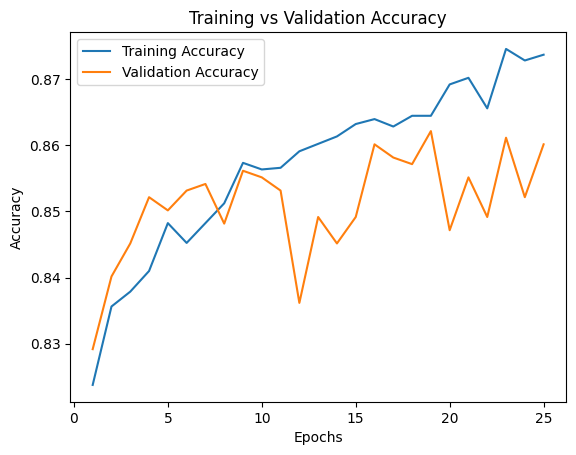

In [21]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
epochs = range(1, len(train_accuracies) + 1)
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.show()


# Model testing and saving

## Test model

In [22]:
test_loader = torch.utils.data.DataLoader(test_imagefolder, batch_size=4, shuffle=False, num_workers=0)

def test_model(model_conv, test_loader, criterion, device):
    model_conv.eval()  # Set model to evaluation mode
    running_loss = 0.0
    running_corrects = 0
    total_samples = 0

    # No need to track gradients during testing
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model_conv(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            # Accumulate loss and correct predictions
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            total_samples += inputs.size(0)

    # Calculate average loss and accuracy
    avg_loss = running_loss / total_samples
    avg_acc = running_corrects.double() / total_samples

    print('Test Loss: {:.4f} Acc: {:.4f}'.format(avg_loss, avg_acc))

test_model(model_conv, test_loader, criterion, device)


Test Loss: 0.3149 Acc: 0.8563


## Save model's state dictionary

In [29]:
# Get the current date
date_str = datetime.datetime.now().strftime("%Y-%m-%d")  # Format as YYYY-MM-DD

# Generate the filename with the date
filename = f"{date_str}_vgg16_finetuned.pth"
load_path = '/content/drive/MyDrive/CancerSkin/src/vgg16_finetuned.pth'

# Save the model state dictionary with the date in the filename
torch.save(model_conv.state_dict(), load_path)

In [28]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Initializing model

In [27]:
# Initialize the model architecture
model_conv = models.vgg16(pretrained=True)

# Freeze all layers again
for param in model_conv.parameters():
    param.requires_grad = False

# Unfreeze the last few layers in the feature extractor (match the training setup)
for param in list(model_conv.features.parameters())[-10:]:
    param.requires_grad = True

# Load the saved state dictionary
model_conv.load_state_dict(torch.load('/content/drive/MyDrive/SkinCancer/MAIS202_Project/src/vgg16_finetuned.pth'))

# Set to evaluation mode if you're using it for inference
model_conv.eval()

<ipython-input-27-82aee232942a>:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_conv.load_state_dict(torch.load('/content/drive/MyDrive/SkinCancer/MAIS202_Project/sr

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/SkinCancer/MAIS202_Project/src/vgg16_finetuned.pth'